## Understanding Simple GRU Fundamentals

### What is a Simple RNN?

A Simple RNN (Recurrent Neural Network) is the most basic form of recurrent neural network that can process sequences of data by maintaining a "memory" of previous inputs.

Key Characteristics:

- Sequential Processing: Processes data one time step at a time

- Memory: Maintains hidden state that carries information from previous time steps

- Parameter Sharing: Uses the same weights across all time steps

- Suitable for: Short sequences (5-10 time steps) due to vanishing gradient problem



### Simple RNN Architecture


In [1]:
# Basic Simple RNN structure
# Input: [batch_size, sequence_length, features]
# Hidden State: [batch_size, hidden_units]
# Output: [batch_size, output_units]

## Code Implementation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Change Working directory

In [4]:
import os
os.chdir('/content/drive/MyDrive/practical_data')
os.listdir()

['text.txt',
 'my_word2vec_model.model',
 'weather_data.csv',
 'best_simple_rnn_model.h5']

### 1.1 Installation and Imports

In [5]:
#Install required packages (run in terminal)
!pip install tensorflow pandas numpy matplotlib scikit-learn seaborn

In [6]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for Simple GRU
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input

# Data preprocessing tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducible results
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Setup completed successfully!")


TensorFlow version: 2.19.0
Setup completed successfully!


### 1.2 Data Loading and Exploration

#### 1.2.1  Load Bangladesh Weather Data

In [7]:
def load_weather_data(file_path):
    """
    Load Bangladesh weather data and create proper structure

    Expected CSV format:
    Year, Day, Wind_Speed, Specific_Humidity, Relative_Humidity, Precipitation, Temperature
    Example: 1990, 240, 3.26, 15.62, 65, 0.69, 30.65
    """

    # Load the CSV file
    df = pd.read_csv('weather_data.csv') #Same working directory

    # Define column names based on your data description
    column_names = [
        'Year', 'Day', 'Wind_Speed', 'Specific_Humidity',
        'Relative_Humidity', 'Precipitation', 'Temperature'
    ]

    # Assign column names if they're not already set
    if len(df.columns) == len(column_names):
        df.columns = column_names

    # Create proper date from Year and Day
    df['Date'] = pd.to_datetime(df['Year'] * 1000 + df['Day'], format='%Y%j')

    # Set date as index for time series analysis
    df.set_index('Date', inplace=True)

    # Remove original Year and Day columns
    df.drop(['Year', 'Day'], axis=1, inplace=True)

    print(f"Data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")

    return df

# Load your data
data_file = "bangladesh_weather_data.csv"  # Replace with your file path
df = load_weather_data(data_file)


Data loaded successfully!
Shape: (12113, 5)
Date range: 1990-01-01 00:00:00 to 2023-03-01 00:00:00


In [8]:
df.head()

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature
Date,,,,,
1990-01-01,1.08,5.68,53.06,0.0,16.33
1990-01-02,1.13,5.92,58.06,0.0,15.68
1990-01-03,1.33,5.68,52.69,0.0,16.56
1990-01-04,1.09,5.19,47.19,0.0,17.09
1990-01-05,0.94,4.82,42.88,0.0,17.26


In [9]:
#Compare with original dataset
main_df = pd.read_csv('weather_data.csv') #Same working directory
main_df.head()

,Year,Day,Wind Speed,Specific Humidity,Relative Humidity,Precipitation,Temperature
0,1990,1,1.08,5.68,53.06,0.0,16.33
1,1990,2,1.13,5.92,58.06,0.0,15.68
2,1990,3,1.33,5.68,52.69,0.0,16.56
3,1990,4,1.09,5.19,47.19,0.0,17.09
4,1990,5,0.94,4.82,42.88,0.0,17.26


#### 1.2.2 Data Exploration and Visualization

=== BANGLADESH WEATHER DATA EXPLORATION ===
Dataset Shape: (12113, 5)
Date Range: 1990-01-01 to 2023-03-01
Total Days: 12113 days
Years Covered: 34 years

=== BASIC STATISTICS ===
       Wind_Speed  Specific_Humidity  Relative_Humidity  Precipitation  \
count    12113.00           12113.00           12113.00       12113.00   
mean         1.31              15.21              74.64           7.18   
std          0.54               5.53              15.29          13.13   
min          0.44               2.62              15.81           0.00   
25%          0.95               9.95              65.25           0.00   
50%          1.15              16.17              79.62           1.16   
75%          1.52              20.57              86.56           9.26   
max          5.34              24.29              96.12         170.63   

       Temperature  
count     12113.00  
mean         25.04  
std           4.37  
min          11.19  
25%          21.43  
50%          26.93  
75%   

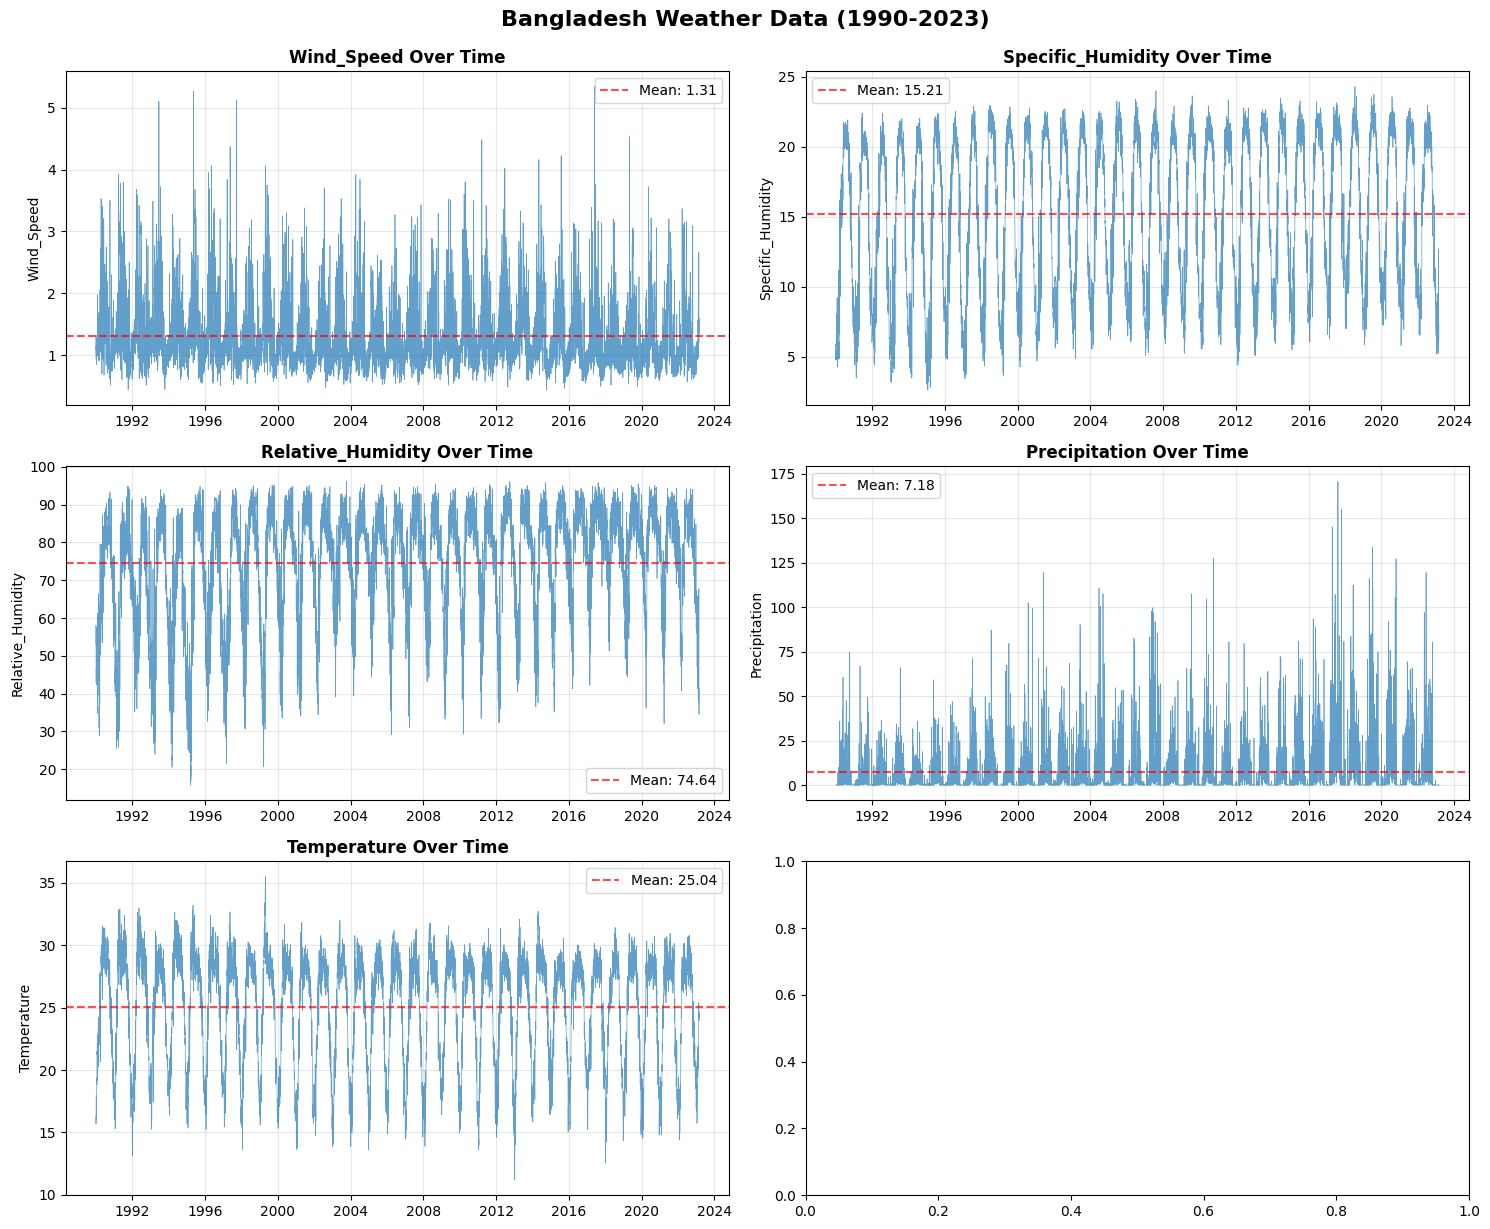

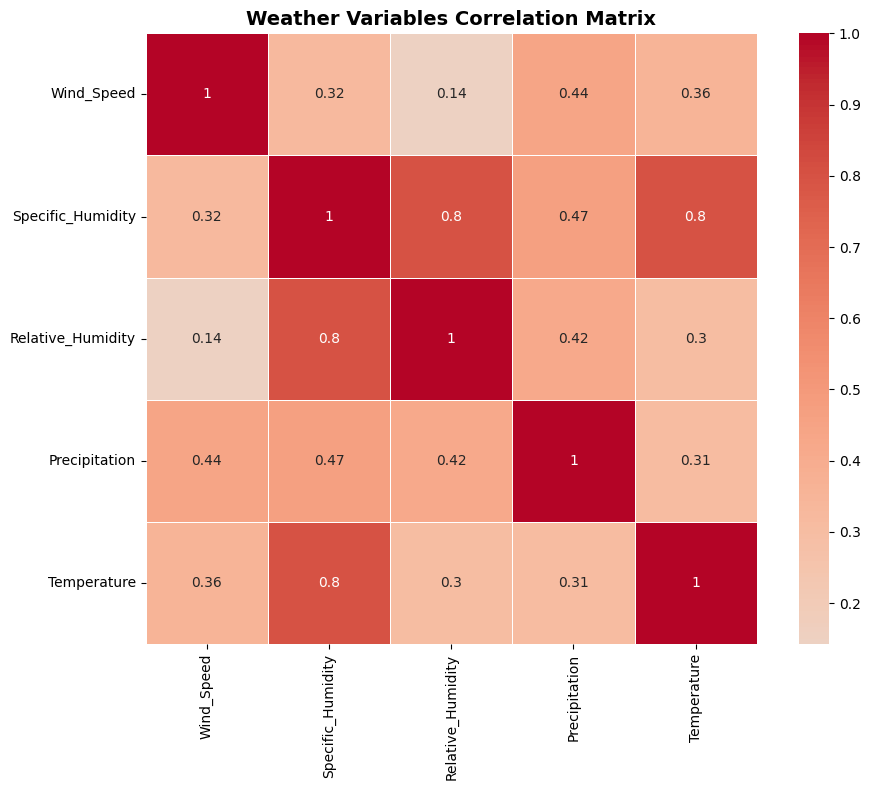

In [10]:
def explore_weather_data(df):
    """
    Comprehensive exploration of weather data
    """

    print("=== BANGLADESH WEATHER DATA EXPLORATION ===")
    print(f"Dataset Shape: {df.shape}")
    print(f"Date Range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    print(f"Total Days: {len(df)} days")
    print(f"Years Covered: {df.index.year.nunique()} years")

    # Basic statistics
    print("\n=== BASIC STATISTICS ===")
    print(df.describe().round(2))

    # Check for missing values
    print("\n=== MISSING VALUES ===")
    missing_values = df.isnull().sum()
    print(missing_values)

    # Data types
    print("\n=== DATA TYPES ===")
    print(df.dtypes)

    # Visualize all weather variables
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        axes[i].plot(df.index, df[column], alpha=0.7, linewidth=0.5)
        axes[i].set_title(f'{column} Over Time', fontsize=12, fontweight='bold')
        axes[i].set_ylabel(column)
        axes[i].grid(True, alpha=0.3)

        # Add some statistics to the plot
        mean_val = df[column].mean()
        axes[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.7,
                       label=f'Mean: {mean_val:.2f}')
        axes[i].legend()

    plt.tight_layout()
    plt.suptitle('Bangladesh Weather Data (1990-2023)', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(10, 8))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Weather Variables Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return df

# Explore the data
df_explored = explore_weather_data(df)


### 1.3 Data Preprocessing for Simple RNN

#### 1.3.1 Data Cleaning

In [11]:
def clean_weather_data(df):
    """
    Clean the weather data for Simple GRU processing
    """

    print("=== DATA CLEANING PROCESS ===")

    # Make a copy to avoid modifying original data
    df_clean = df.copy()

    # 1. Handle missing values
    print(f"Missing values before cleaning: {df_clean.isnull().sum().sum()}")

    # Forward fill then backward fill for time series data
    df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')

    print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")

    # 2. Remove outliers using IQR method
    print("\n=== OUTLIER REMOVAL ===")

    for column in df_clean.columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers_before = ((df_clean[column] < lower_bound) |
                          (df_clean[column] > upper_bound)).sum()

        # Remove outliers by clipping
        df_clean[column] = df_clean[column].clip(lower=lower_bound, upper=upper_bound)

        print(f"{column}: {outliers_before} outliers handled")

    # 3. Basic feature engineering for time series
    df_clean['Month'] = df_clean.index.month
    df_clean['Day_of_Year'] = df_clean.index.dayofyear

    # Add simple moving averages (helpful for Simple RNN)
    df_clean['Temp_MA_3'] = df_clean['Temperature'].rolling(window=3).mean()
    df_clean['Temp_MA_7'] = df_clean['Temperature'].rolling(window=7).mean()

    # Remove rows with NaN values created by moving averages
    df_clean.dropna(inplace=True)

    print(f"\nFinal dataset shape: {df_clean.shape}")

    return df_clean

# Clean the data
df_clean = clean_weather_data(df_explored)

=== DATA CLEANING PROCESS ===
Missing values before cleaning: 0
Missing values after cleaning: 0

=== OUTLIER REMOVAL ===
Wind_Speed: 661 outliers handled
Specific_Humidity: 0 outliers handled
Relative_Humidity: 152 outliers handled
Precipitation: 1089 outliers handled
Temperature: 0 outliers handled

Final dataset shape: (12107, 9)


/tmp/ipython-input-2519697218.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')


In [21]:
df_clean.head()

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature,Month,Day_of_Year,Temp_MA_3,Temp_MA_7
Date,,,,,,,,,
1990-01-07,1.04,5.49,46.81,0.0,17.98,1,7,17.510000,16.884286
1990-01-08,1.06,5.07,44.25,0.0,17.58,1,8,17.616667,17.062857
1990-01-09,0.85,4.82,42.31,0.0,17.25,1,9,17.603333,17.287143
1990-01-10,1.14,4.76,45.38,0.0,16.33,1,10,17.053333,17.254286
1990-01-11,1.07,5.07,48.44,0.0,16.15,1,11,16.576667,17.120000


#### 1.3.2 Data Normalization (Critical for Simple RNN)


In [12]:
def normalize_data_for_gru(df, target_column='Temperature'):
    """
    Normalize data for Simple GRU training

    Important: We fit the scaler only on training data to prevent data leakage
    """

    print(f"=== DATA NORMALIZATION FOR SIMPLE GRU ===")
    print(f"Target variable: {target_column}")

    # Separate features and target
    feature_columns = [col for col in df.columns if col != target_column]

    print(f"Feature columns: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")

    # Initialize scalers
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))

    return df, feature_columns, feature_scaler, target_scaler

# Prepare for normalization
df_processed, feature_columns, feature_scaler, target_scaler = normalize_data_for_gru(df_clean)

=== DATA NORMALIZATION FOR SIMPLE GRU ===
Target variable: Temperature
Feature columns: ['Wind_Speed', 'Specific_Humidity', 'Relative_Humidity', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Number of features: 8


In [13]:
df_processed.head(2)

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature,Month,Day_of_Year,Temp_MA_3,Temp_MA_7
Date,,,,,,,,,
1990-01-07,1.04,5.49,46.81,0.0,17.98,1,7,17.510000,16.884286
1990-01-08,1.06,5.07,44.25,0.0,17.58,1,8,17.616667,17.062857


These lines are for basic feature engineering in time series analysis, which helps a neural network learn patterns better by adding informative features derived from the raw data.

What are these features?
- Month: The month from each date (e.g., January, February, etc.), which helps encode potential seasonal effects (like monsoons or cold seasons).

- Day_of_Year: The position of each date in the year (e.g., 1 for January 1st, 365 for December 31st), which can capture cyclic trends and annual seasonality.

- Temp_MA_3: The average temperature over the past 3 days for each day.

- Temp_MA_7: The average temperature over the past 7 days for each day.

Why are they done?
- Month and Day_of_Year transform raw date information into numerical features so that machine learning models can learn from seasonal patterns (e.g., temperature might be higher in June than in December).

- Moving averages (Temp_MA_3 and Temp_MA_7) smooth the original temperature signal. They reduce noise and short-term fluctuations, making longer-term trends and cycles more visible for the model. These features help the neural network understand not just today's temperature but also recent context, which is important for forecasting.

Why do we do this for time series models?
- Expose Patterns: Weather data shows seasonal/cyclic behaviors; encoding month and day-of-year helps the model pick up on regular patterns.

- Reduce Noise: Moving averages help to “smooth out” outlier values, giving the model a clearer picture of underlying trends.

Learning Context: RNNs thrive when they can access recent history. Including moving averages lets the model access summarized context of the recent past, not just raw daily values

#### 1.3.3 Time Series Train-Test Split

In [22]:
def create_time_series_split(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Create time-aware train/validation/test split for time series

    Important: No shuffling to maintain temporal order!
    """

    print(f"=== TIME SERIES DATA SPLITTING ===")

    n_samples = len(df)

    # Calculate split indices
    train_end = int(n_samples * train_ratio)
    val_end = int(n_samples * (train_ratio + val_ratio))

    # Split data maintaining temporal order
    train_data = df.iloc[:train_end].copy()
    val_data = df.iloc[train_end:val_end].copy()
    test_data = df.iloc[val_end:].copy()

    print(f"Training data: {len(train_data)} samples ({train_data.index.min()} to {train_data.index.max()})")
    print(f"Validation data: {len(val_data)} samples ({val_data.index.min()} to {val_data.index.max()})")
    print(f"Test data: {len(test_data)} samples ({test_data.index.min()} to {test_data.index.max()})")

    return train_data, val_data, test_data

# Split the data
train_data, val_data, test_data = create_time_series_split(df_processed)

=== TIME SERIES DATA SPLITTING ===
Training data: 8474 samples (1990-01-07 00:00:00 to 2013-03-20 00:00:00)
Validation data: 1816 samples (2013-03-21 00:00:00 to 2018-03-10 00:00:00)
Test data: 1817 samples (2018-03-11 00:00:00 to 2023-03-01 00:00:00)


In [23]:
train_data.head(2)

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature,Month,Day_of_Year,Temp_MA_3,Temp_MA_7
Date,,,,,,,,,
1990-01-07,1.04,5.49,46.81,0.0,17.98,1,7,17.510000,16.884286
1990-01-08,1.06,5.07,44.25,0.0,17.58,1,8,17.616667,17.062857


### 1.4 Creating Sequences for Simple RNN

#### Understanding Sequence Creation
Simple RNNs work best with shorter sequences (5-7 days) due to the vanishing gradient problem. Here's how we create sequences:



In [24]:
def create_sequences_for_simple_gru(features, target, sequence_length=30):
    """
    Create sequences for Simple GRU training

    For Simple GRU, we use shorter sequences (5-7 days) for better performance

    Parameters:
    - data: scaled data array
    - target_column: index of target column
    - sequence_length: number of time steps to look back (keep it short for Simple GRU)
    """

    sequences = []
    targets = []

    # Create sequences
    for i in range(sequence_length, len(features)):
        # Get sequence of past 'sequence_length' days
        sequences.append(features[i-sequence_length:i])  # Shape: (sequence_length, features)

        # Get target (next day's temperature)
        targets.append(target[i])  # Single value

    return np.array(sequences), np.array(targets)

In [25]:
def prepare_data_for_simple_gru(train_data, val_data, test_data,
                               feature_columns, target_column,
                               feature_scaler, target_scaler,
                               sequence_length=30):
    """
    Complete data preparation pipeline for Simple GRU
    """

    print(f"=== PREPARING DATA FOR SIMPLE GRU ===")
    print(f"Sequence length: {sequence_length} days")
    print(f"Target: {target_column}")
    print(f"Features: {feature_columns}")

    # 1. Scale the data (fit only on training data!)
    train_features_scaled = feature_scaler.fit_transform(train_data[feature_columns])
    train_target_scaled = target_scaler.fit_transform(train_data[[target_column]])
    print(f"Train Target : {train_target_scaled.flatten().shape}")

    val_features_scaled = feature_scaler.transform(val_data[feature_columns])
    val_target_scaled = target_scaler.transform(val_data[[target_column]])

    test_features_scaled = feature_scaler.transform(test_data[feature_columns])
    test_target_scaled = target_scaler.transform(test_data[[target_column]])

    # 2. Combine features and target for sequence creation
    train_combined = np.column_stack([train_features_scaled, train_target_scaled])
    val_combined = np.column_stack([val_features_scaled, val_target_scaled])
    test_combined = np.column_stack([test_features_scaled, test_target_scaled])

    # 3. Find target column index in combined array
    #target_idx = train_data.columns.get_loc('Temperature')

    # 4. Create sequences
    X_train, y_train = create_sequences_for_simple_gru(train_features_scaled, train_target_scaled.flatten(), sequence_length)
    X_val, y_val = create_sequences_for_simple_gru(val_features_scaled, val_target_scaled.flatten(), sequence_length)
    X_test, y_test = create_sequences_for_simple_gru(test_features_scaled, test_target_scaled.flatten(), sequence_length)


    print(f"Training sequences: {X_train.shape}")
    print(f"Training targets: {y_train.shape}")
    print(f"Validation sequences: {X_val.shape}")
    print(f"Test sequences: {X_test.shape}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Prepare sequences (using short sequence length for Simple RNN)
SEQUENCE_LENGTH = 30  # Only 5 days - optimal for Simple RNN

(X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_data_for_simple_gru(
    train_data, val_data, test_data,
    feature_columns, 'Temperature',
    feature_scaler, target_scaler,
    sequence_length=SEQUENCE_LENGTH
)

print("Data preparation completed successfully!")

=== PREPARING DATA FOR SIMPLE GRU ===
Sequence length: 30 days
Target: Temperature
Features: ['Wind_Speed', 'Specific_Humidity', 'Relative_Humidity', 'Precipitation', 'Month', 'Day_of_Year', 'Temp_MA_3', 'Temp_MA_7']
Train Target : (8474,)
Training sequences: (8444, 30, 8)
Training targets: (8444,)
Validation sequences: (1786, 30, 8)
Test sequences: (1787, 30, 8)
Data preparation completed successfully!


In [26]:
X_train[100]

array([[5.35064935e-01, 5.97098737e-01, 4.83886369e-01, 4.40604752e-02,
        2.72727273e-01, 2.90410959e-01, 7.44755737e-01, 7.23740253e-01],
       [1.00000000e+00, 6.08329434e-01, 5.04734622e-01, 1.58099352e-01,
        2.72727273e-01, 2.93150685e-01, 7.42925524e-01, 7.31800013e-01],
       [1.00000000e+00, 5.97098737e-01, 4.99801066e-01, 2.19006479e-01,
        2.72727273e-01, 2.95890411e-01, 7.33633676e-01, 7.32258699e-01],
       [1.00000000e+00, 6.88348152e-01, 6.54014482e-01, 8.13822894e-01,
        2.72727273e-01, 2.98630137e-01, 7.19132761e-01, 7.25640522e-01],
       [1.00000000e+00, 7.22976135e-01, 7.36452614e-01, 1.00000000e+00,
        2.72727273e-01, 3.01369863e-01, 6.98155709e-01, 7.19939716e-01],
       [8.88311688e-01, 7.20168460e-01, 6.78841410e-01, 4.15118790e-01,
        2.72727273e-01, 3.04109589e-01, 6.92524286e-01, 7.15418387e-01],
       [8.05194805e-01, 6.94431446e-01, 5.94175221e-01, 6.00431965e-02,
        2.72727273e-01, 3.06849315e-01, 7.10404055e-01, 7.

### 1.5 Building Simple RNN Model

#### 1.5.1 Understanding Simple RNN Architecture

In [27]:
def create_simple_gru_model(input_shape, hidden_units=32, dropout_rate=0.2):
    """
    Create a Simple GRU model optimized for weather prediction

    Architecture:
    1. SimpleGRU layer with specified hidden units
    2. Dropout for regularization
    3. Dense layer for final prediction

    Parameters:
    - input_shape: (sequence_length, number_of_features)
    - hidden_units: number of neurons in GRU layer
    - dropout_rate: dropout rate for regularization
    """

    print(f"=== BUILDING SIMPLE GRU MODEL ===")
    print(f"Input shape: {input_shape}")
    print(f"Hidden units: {hidden_units}")
    print(f"Dropout rate: {dropout_rate}")

    model = Sequential(name="Simple_GRU_Weather_Predictor")

    # Add Input layer to specify input shape
    model.add(Input(shape=input_shape, name='Input_Layer'))

    # Add GRU layer without input_shape argument
    model.add(GRU(
        units=hidden_units,
        activation='tanh',  # Default activation
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate,
        name='SimpleGRU_Layer'
    ))


    # Add dropout for additional regularization
    model.add(Dropout(dropout_rate, name='Dropout_Layer'))

    # Add dense layer for final prediction
    model.add(Dense(
        units=1,
        activation='linear',  # Linear activation for regression
        name='Output_Layer'
    ))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mean_absolute_error', 'mean_absolute_percentage_error']
    )

    # Display model summary
    print("\n=== MODEL ARCHITECTURE ===")
    model.summary()

    return model

# Create the Simple RNN model
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, features)
model = create_simple_gru_model(input_shape, hidden_units=32, dropout_rate=0.2)

=== BUILDING SIMPLE GRU MODEL ===
Input shape: (30, 8)
Hidden units: 32
Dropout rate: 0.2

=== MODEL ARCHITECTURE ===


Model: "Simple_GRU_Weather_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleGRU_Layer (GRU)           │ (None, 32)             │         4,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,065 (15.88 KB)

 Trainable params: 4,065 (15.88 KB)

 Non-trainable params: 0 (0.00 B)

#### 1.5.2 Model Training Strategy

In [30]:
def train_simple_gru_model(model, X_train, y_train, X_val, y_val,
                          epochs=100, batch_size=32, patience=10):
    """
    Train Simple GRU model with proper callbacks

    Simple RNN training considerations:
    - Lower epochs (50) due to faster convergence
    - Early stopping to prevent overfitting
    - Learning rate reduction for better convergence
    """

    print(f"=== TRAINING SIMPLE RNN MODEL ===")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Epochs: {epochs}")
    print(f"Batch size: {batch_size}")

    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001
        ),
        ModelCheckpoint(
            'best_simple_rnn_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train the model
    print("\nStarting training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1,
        shuffle=False  # Important: Don't shuffle time series data
    )

    print("Training completed!")
    return history

# Train the model
training_history = train_simple_gru_model(
    model, X_train, y_train, X_val, y_val,
    epochs=100, batch_size=32, patience=10
)


=== TRAINING SIMPLE RNN MODEL ===
Training samples: 8444
Validation samples: 1786
Epochs: 100
Batch size: 32

Starting training...
Epoch 1/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0658 - mean_absolute_error: 0.1985 - mean_absolute_percentage_error: 506.9980
Epoch 1: val_loss improved from inf to 0.00631, saving model to best_simple_rnn_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0657 - mean_absolute_error: 0.1983 - mean_absolute_percentage_error: 660.6548 - val_loss: 0.0063 - val_mean_absolute_error: 0.0626 - val_mean_absolute_percentage_error: 13.7351
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0253 - mean_absolute_error: 0.1259 - mean_absolute_percentage_error: 462.9649
Epoch 2: val_loss improved from 0.00631 to 0.00587, saving model to best_simple_rnn_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0253 - mean_absolute_error: 0.1259 - mean_absolute_percentage_error: 606.1227 - val_loss: 0.0059 - val_mean_absolute_error: 0.0594 - val_mean_absolute_percentage_error: 13.4122
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0218 - mean_absolute_error: 0.1170 - mean_absolute_percentage_error: 449.6188
Epoch 3: val_loss improved from 0.00587 to 0.00512, saving model to best_simple_rnn_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0218 - mean_absolute_error: 0.1170 - mean_absolute_percentage_error: 588.8833 - val_loss: 0.0051 - val_mean_absolute_error: 0.0546 - val_mean_absolute_percentage_error: 12.3162
Epoch 4/100
263/264 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0192 - mean_absolute_error: 0.1099 - mean_absolute_percentage_error: 287.6645
Epoch 4: val_loss did not improve from 0.00512
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0192 - mean_absolute_error: 0.1098 - mean_absolute_percentage_error: 547.5107 - val_loss: 0.0060 - val_mean_absolute_error: 0.0625 - val_mean_absolute_percentage_error: 12.9877
Epoch 5/100
262/264 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0168 - mean_absolute_error: 0.1020 - mean_absolute_percentage_error: 165.4588
Epoch 5: val_loss did not improve from 0.00512
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0167 - mean_absolute_error: 0.1019 - mean_absolute_percentage_error: 589.4813 - val_loss: 0.0089 - val_mean_abs

### 1.6 Model Evaluation and Visualization

#### 1.6.1 Training History Visualization

=== TRAINING HISTORY VISUALIZATION ===


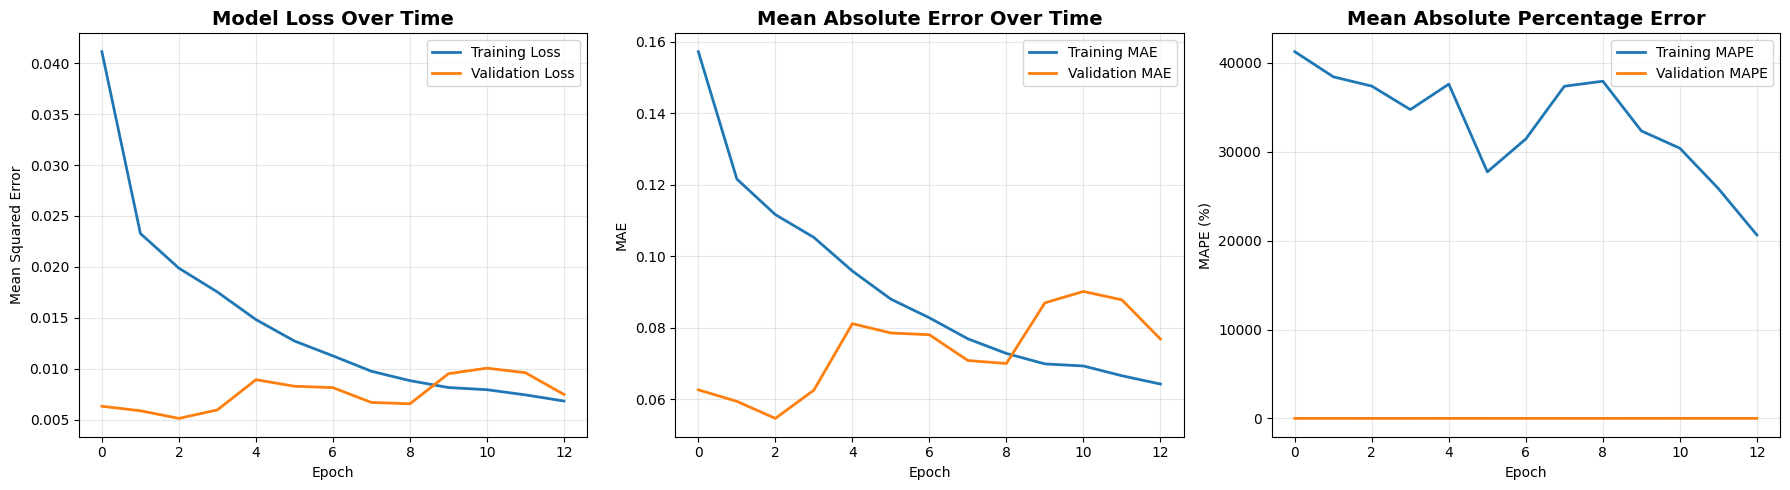

In [32]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Visualize training history for Simple RNN
    """

    print("=== TRAINING HISTORY VISUALIZATION ===")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Mean Squared Error')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # MAE plot
    axes[1].plot(history.history['mean_absolute_error'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE', linewidth=2)
    axes[1].set_title('Mean Absolute Error Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # MAPE plot
    axes[2].plot(history.history['mean_absolute_percentage_error'],
                label='Training MAPE', linewidth=2)
    axes[2].plot(history.history['val_mean_absolute_percentage_error'],
                label='Validation MAPE', linewidth=2)
    axes[2].set_title('Mean Absolute Percentage Error', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('MAPE (%)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(training_history)

#### 1.6.2 Model Performance Evaluation

In [33]:
def evaluate_simple_gru_performance(model, X_test, y_test, target_scaler):
    """
    Comprehensive evaluation of Simple RNN performance
    """

    print("=== SIMPLE RNN MODEL EVALUATION ===")

    # Make predictions
    y_pred_scaled = model.predict(X_test, verbose=0)

    # Inverse transform to original scale
    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred_scaled).flatten()

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    # Calculate MAPE manually
    mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

    # Temperature-specific accuracy (within certain degrees)
    accuracy_1deg = np.mean(np.abs(y_test_original - y_pred_original) <= 1.0) * 100
    accuracy_2deg = np.mean(np.abs(y_test_original - y_pred_original) <= 2.0) * 100
    accuracy_3deg = np.mean(np.abs(y_test_original - y_pred_original) <= 3.0) * 100

    # Print results
    print("\n🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️")
    print("=" * 55)
    print(f"📊 Mean Squared Error (MSE):      {mse:.4f}")
    print(f"📊 Root Mean Squared Error (RMSE): {rmse:.4f}°C")
    print(f"📊 Mean Absolute Error (MAE):     {mae:.4f}°C")
    print(f"📊 R-squared Score (R²):          {r2:.4f}")
    print(f"📊 Mean Absolute Percentage Error: {mape:.2f}%")
    print("=" * 55)
    print("🎯 TEMPERATURE PREDICTION ACCURACY:")
    print(f"   Within ±1°C: {accuracy_1deg:.1f}% of predictions")
    print(f"   Within ±2°C: {accuracy_2deg:.1f}% of predictions")
    print(f"   Within ±3°C: {accuracy_3deg:.1f}% of predictions")
    print("=" * 55)

    return {
        'y_true': y_test_original,
        'y_pred': y_pred_original,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'accuracy_1deg': accuracy_1deg,
        'accuracy_2deg': accuracy_2deg,
        'accuracy_3deg': accuracy_3deg
    }

# Evaluate the model
evaluation_results = evaluate_simple_gru_performance(model, X_test, y_test, target_scaler)

=== SIMPLE RNN MODEL EVALUATION ===

🌤️  SIMPLE RNN WEATHER PREDICTION RESULTS 🌤️
📊 Mean Squared Error (MSE):      3.2615
📊 Root Mean Squared Error (RMSE): 1.8060°C
📊 Mean Absolute Error (MAE):     1.4085°C
📊 R-squared Score (R²):          0.8276
📊 Mean Absolute Percentage Error: 6.14%
🎯 TEMPERATURE PREDICTION ACCURACY:
   Within ±1°C: 43.9% of predictions
   Within ±2°C: 76.7% of predictions
   Within ±3°C: 90.2% of predictions


#### 1.6.3 Prediction Visualization

=== PREDICTION VISUALIZATION ===


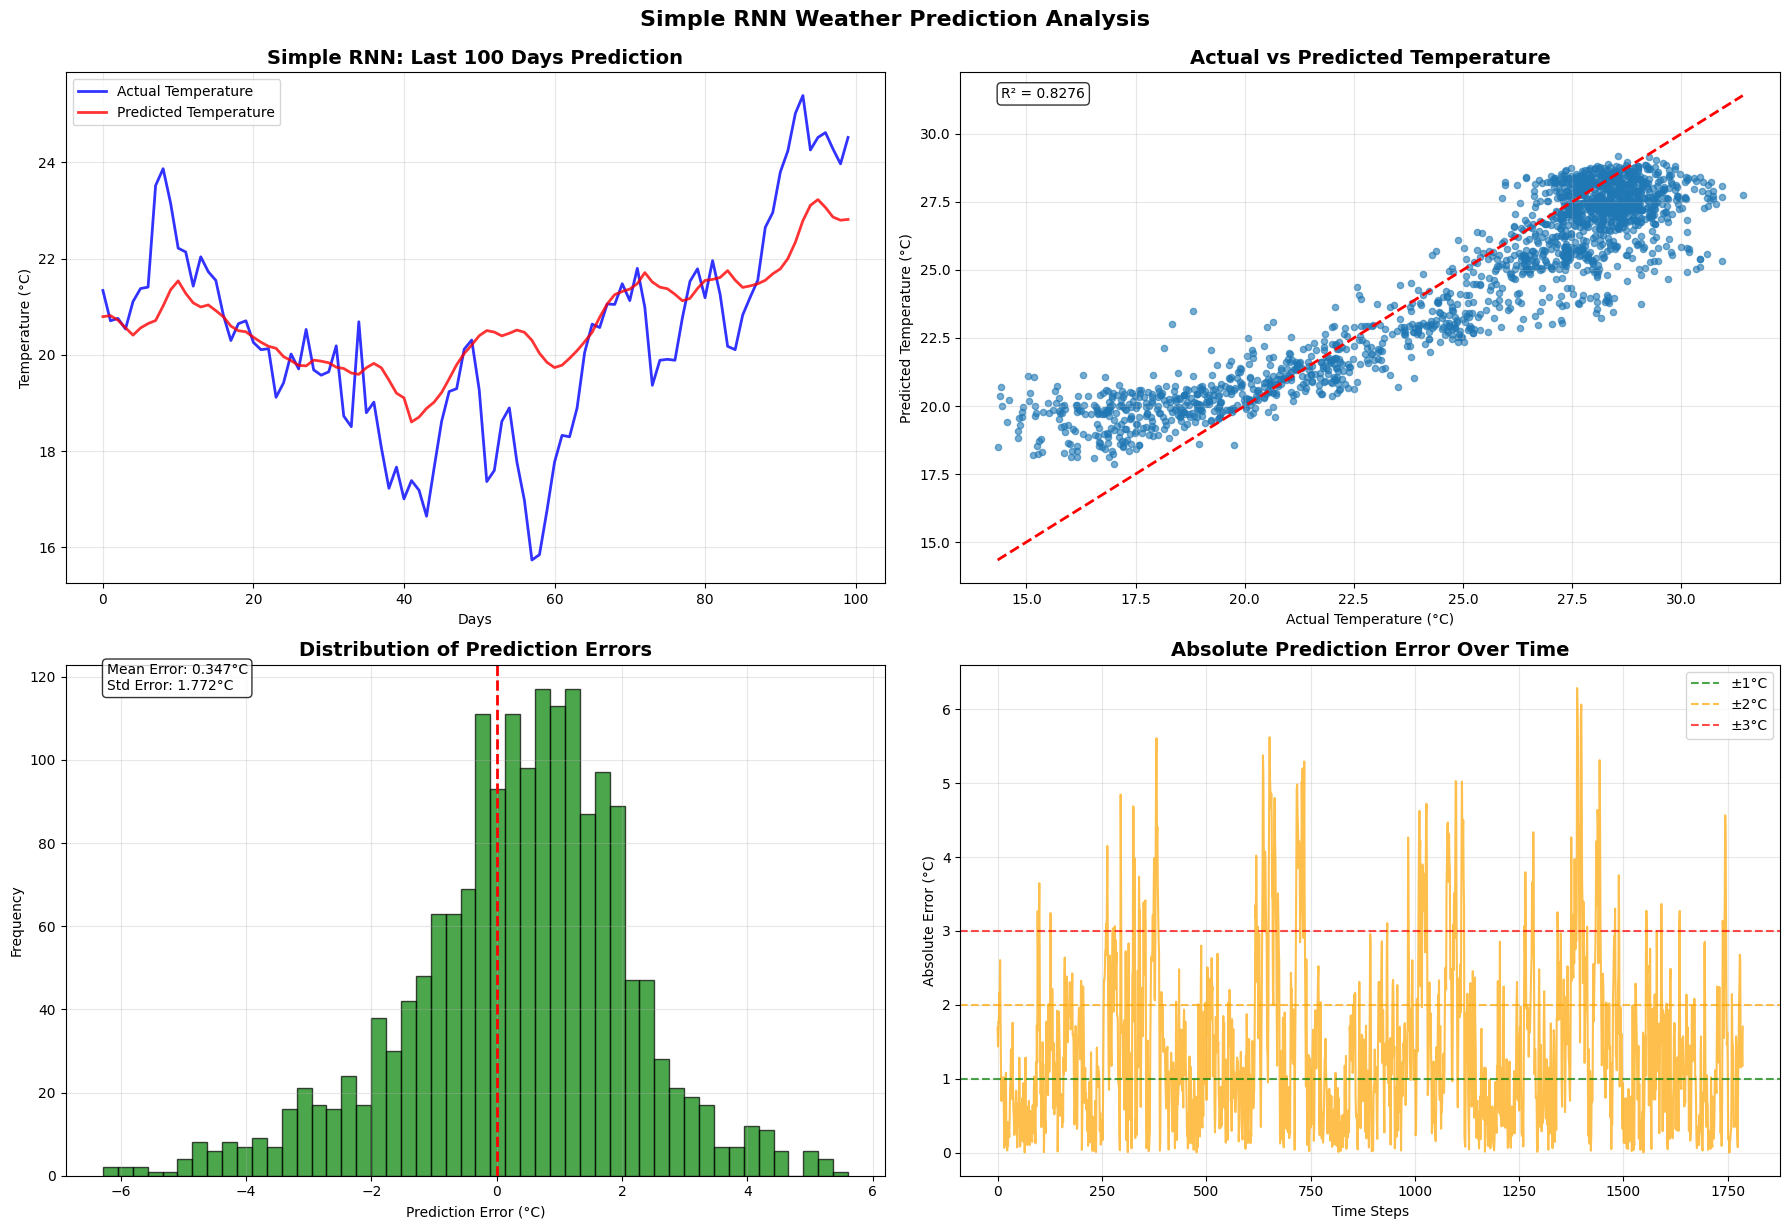

In [34]:
def visualize_predictions(results, days_to_show=100):
    """
    Create comprehensive visualizations of Simple RNN predictions
    """

    print(f"=== PREDICTION VISUALIZATION ===")

    y_true = results['y_true']
    y_pred = results['y_pred']

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # 1. Time series plot (last N days)
    axes[0, 0].plot(y_true[-days_to_show:], label='Actual Temperature',
                   linewidth=2, alpha=0.8, color='blue')
    axes[0, 0].plot(y_pred[-days_to_show:], label='Predicted Temperature',
                   linewidth=2, alpha=0.8, color='red')
    axes[0, 0].set_title(f'Simple RNN: Last {days_to_show} Days Prediction',
                        fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Days')
    axes[0, 0].set_ylabel('Temperature (°C)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Scatter plot: Actual vs Predicted
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6, s=20)
    min_temp, max_temp = y_true.min(), y_true.max()
    axes[0, 1].plot([min_temp, max_temp], [min_temp, max_temp], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Temperature (°C)')
    axes[0, 1].set_ylabel('Predicted Temperature (°C)')
    axes[0, 1].set_title('Actual vs Predicted Temperature', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Add R² to scatter plot
    r2 = results['r2']
    axes[0, 1].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0, 1].transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 3. Error distribution
    errors = y_true - y_pred
    axes[1, 0].hist(errors, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Prediction Error (°C)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Add error statistics
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    axes[1, 0].text(0.05, 0.95, f'Mean Error: {mean_error:.3f}°C\nStd Error: {std_error:.3f}°C',
                   transform=axes[1, 0].transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 4. Error over time
    axes[1, 1].plot(np.abs(errors), alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('Time Steps')
    axes[1, 1].set_ylabel('Absolute Error (°C)')
    axes[1, 1].set_title('Absolute Prediction Error Over Time', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    # Add horizontal lines for accuracy thresholds
    axes[1, 1].axhline(1, color='green', linestyle='--', alpha=0.7, label='±1°C')
    axes[1, 1].axhline(2, color='orange', linestyle='--', alpha=0.7, label='±2°C')
    axes[1, 1].axhline(3, color='red', linestyle='--', alpha=0.7, label='±3°C')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.suptitle('Simple RNN Weather Prediction Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Visualize predictions
visualize_predictions(evaluation_results, days_to_show=100)


#### 1.6.4 Real-time Prediction Function

In [37]:
def make_weather_prediction(model, recent_data, feature_scaler, target_scaler,
                           feature_columns, sequence_length=5):
    """
    Make a weather prediction using the trained Simple RNN model

    Parameters:
    - model: trained Simple RNN model
    - recent_data: pandas DataFrame with recent weather data (last 'sequence_length' days)
    - feature_scaler: fitted feature scaler
    - target_scaler: fitted target scaler
    - feature_columns: list of feature column names
    - sequence_length: number of days to use for prediction
    """

    print(f"=== MAKING NEW WEATHER PREDICTION ===")

    if len(recent_data) < sequence_length:
        raise ValueError(f"Need at least {sequence_length} days of recent data")

    # Get the last sequence_length days
    recent_sequence = recent_data[feature_columns].iloc[-sequence_length-1:-1].values

    # Scale the data
    #recent_sequence_scaled = feature_scaler.transform(recent_sequence)

    #Convert recent_sequence (numpy array) back to DataFrame with columns for scaler
    recent_sequence_df = pd.DataFrame(recent_sequence, columns=feature_columns)
    print(recent_sequence_df)


    # Now transform with feature scaler (which expects column names)
    recent_sequence_scaled = feature_scaler.transform(recent_sequence_df)

    # Reshape for model input: (1, sequence_length, features)
    input_sequence = recent_sequence_scaled.reshape(1, sequence_length, -1)

    # Make prediction (scaled)
    prediction_scaled = model.predict(input_sequence, verbose=0)

    # Inverse transform to get actual temperature
    predicted_temp = target_scaler.inverse_transform(prediction_scaled)[0, 0]

    print(f"🌡️  Predicted temperature for tomorrow: {predicted_temp:.2f}°C")

    return predicted_temp

# Example: Make prediction using last 5 days of test data
sample_recent_data = test_data.iloc[-31:]  # Last 10 days as example
prediction = make_weather_prediction(
    model, sample_recent_data, feature_scaler, target_scaler,
    feature_columns, sequence_length=SEQUENCE_LENGTH
)


=== MAKING NEW WEATHER PREDICTION ===
    Wind_Speed  Specific_Humidity  Relative_Humidity  Precipitation  Month  \
0        1.090               7.81              53.06           0.00    1.0   
1        1.160               8.42              57.12           0.00    1.0   
2        1.000               8.73              56.12           0.00    2.0   
3        0.950               5.74              41.25           0.00    2.0   
4        1.100               6.23              46.81           0.00    2.0   
5        0.980               7.57              54.44           0.00    2.0   
6        1.040               7.39              54.31           0.00    2.0   
7        1.240               6.53              47.94           0.00    2.0   
8        1.570               7.14              48.81           0.00    2.0   
9        1.380               9.34              62.69           0.04    2.0   
10       1.320               9.46              60.94           0.02    2.0   
11       1.310            

In [38]:
df_clean.tail(5)

,Wind_Speed,Specific_Humidity,Relative_Humidity,Precipitation,Temperature,Month,Day_of_Year,Temp_MA_3,Temp_MA_7
Date,,,,,,,,,
2023-02-25,1.28,8.85,50.44,0.0,24.52,2,56,24.723333,24.312857
2023-02-26,1.41,6.59,38.06,0.0,24.62,2,57,24.466667,24.550000
2023-02-27,1.60,6.04,34.56,0.0,24.28,2,58,24.473333,24.618571
2023-02-28,1.49,6.65,38.94,0.0,23.97,2,59,24.290000,24.580000
2023-03-01,1.36,7.39,41.38,0.0,24.52,3,60,24.256667,24.508571


In [39]:
print(f"Actual Temperture value of last data: {df_clean.tail(5)['Temperature'].values[-1]}")

Actual Temperture value of last data: 24.52


### Understanding Simple RNN Limitations

In [ ]:
def analyze_simple_rnn_limitations():
    """
    Educational analysis of Simple RNN limitations for students
    """

    print("=== UNDERSTANDING SIMPLE RNN LIMITATIONS ===")
    print("\n🧠 WHY SIMPLE RNN HAS LIMITATIONS:")
    print("=" * 50)

    print("1. 📉 VANISHING GRADIENT PROBLEM:")
    print("   - Gradients become very small as they propagate back through time")
    print("   - Model struggles to learn from events more than 5-10 time steps ago")
    print("   - Weather patterns often require longer memory (weeks/months)")

    print("\n2. 🔄 SHORT-TERM MEMORY:")
    print("   - Simple RNN forgets information from distant past quickly")
    print("   - Weather has seasonal patterns that need long-term memory")
    print("   - Best performance with 3-7 day sequences")

    print("\n3. 🎯 PERFORMANCE COMPARISON:")
    print("   - Simple RNN: Good for short-term patterns")
    print("   - LSTM/GRU: Better for long-term dependencies")
    print("   - Complex weather patterns need advanced models")

    print("\n💡 WHEN TO USE SIMPLE RNN:")
    print("   ✅ Learning RNN fundamentals")
    print("   ✅ Short-term predictions (1-3 days)")
    print("   ✅ Simple patterns and trends")
    print("   ✅ Computational resource constraints")
    print("   ✅ Proof of concept projects")

    print("\n🚀 NEXT STEPS FOR STUDENTS:")
    print("   1. Master Simple RNN concepts")
    print("   2. Learn LSTM architecture")
    print("   3. Compare performance differences")
    print("   4. Understand when to use each model")
    print("=" * 50)

# Run the educational analysis
analyze_simple_rnn_limitations()

### Student Exercises

In [ ]:
def student_exercises():
    """
    Hands-on exercises for students to reinforce learning
    """

    print("📚 STUDENT EXERCISES - SIMPLE RNN WEATHER PREDICTION")
    print("=" * 60)

    exercises = [
        {
            "title": "Exercise 1: Experiment with Sequence Length",
            "description": "Try different sequence lengths (3, 5, 7, 10) and observe performance changes",
            "code_hint": "modify sequence_length parameter in prepare_data_for_simple_rnn()",
            "expected_outcome": "Understand how sequence length affects Simple RNN performance"
        },
        {
            "title": "Exercise 2: Change Hidden Units",
            "description": "Test different hidden layer sizes (16, 32, 64, 128)",
            "code_hint": "modify hidden_units parameter in create_simple_rnn_model()",
            "expected_outcome": "Learn about model capacity and overfitting"
        },
        {
            "title": "Exercise 3: Feature Selection",
            "description": "Try using different combinations of weather features",
            "code_hint": "modify feature_columns list before training",
            "expected_outcome": "Understand which features are most important for prediction"
        },
        {
            "title": "Exercise 4: Predict Different Variables",
            "description": "Try predicting humidity or wind speed instead of temperature",
            "code_hint": "change target_column parameter to 'Relative_Humidity' or 'Wind_Speed'",
            "expected_outcome": "See how model performs on different weather variables"
        },
        {
            "title": "Exercise 5: Error Analysis",
            "description": "Identify when the model makes the largest errors",
            "code_hint": "analyze prediction errors by season or weather conditions",
            "expected_outcome": "Understand model limitations and failure cases"
        }
    ]

    for i, exercise in enumerate(exercises, 1):
        print(f"\n🎯 {exercise['title']}")
        print(f"   📝 Task: {exercise['description']}")
        print(f"   💡 Hint: {exercise['code_hint']}")
        print(f"   🎯 Goal: {exercise['expected_outcome']}")

    print("\n" + "=" * 60)
    print("💡 Remember: Simple RNN is a stepping stone to advanced models!")

# Display exercises
student_exercises()
